# Преобразование 2D-изображения

In [2]:
import numpy as np
import pywt
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

Пользовательские функции:

In [3]:
from Functions.combine_matrices import combine_matrices
from Functions.split_matrices import split_matrices

## Импорт изображения из файла

In [4]:
from PIL import Image
# Load a BMP image
image_path = 'images/couple.bmp'
img = Image.open(image_path)

# Display basic information about the image
print(f"Image Format: {img.format}")
print(f"Image Size: {img.size}")
print(f"Image Mode: {img.mode}")

f = (np.matrix(img) / 255).astype(float)
[Nrow, Ncol] = np.shape(f)

Image Format: BMP
Image Size: (512, 512)
Image Mode: L


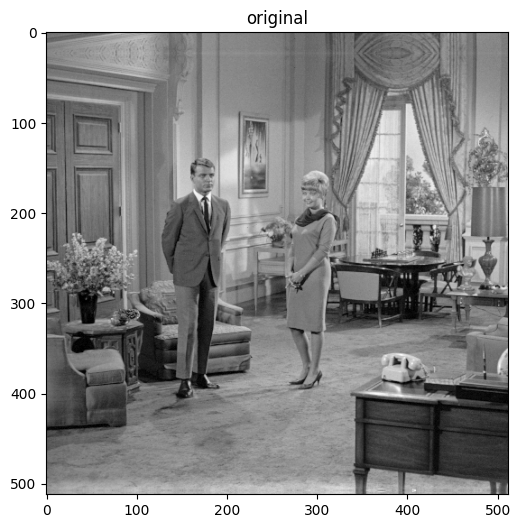

In [5]:
plt.figure(figsize=(8,6))
plt.imshow(f, cmap='gray')
plt.title('original')
plt.savefig('readme_img/original.png', bbox_inches='tight')
plt.show()

## Преобразование 'db1'

### Кратномасштабный анализ

In [6]:
# Number of levels.
K = 4
# Wavelet type.
wavelet = 'db1'

user_fontsize = 14

coeff = np.empty(K, dtype='object')
for k in range(K):
    if k == 0:
        coeff[k] = f.copy()
    else:
        coeff[k] = coeff[k-1].copy()
    cA, (cH, cV, cD) = pywt.dwt2(coeff[k][:Nrow//2**k,:Ncol//2**k], wavelet)
    coeff[k][:Nrow//2**k,:Ncol//2**k] = combine_matrices(cA, cH, cV, cD)

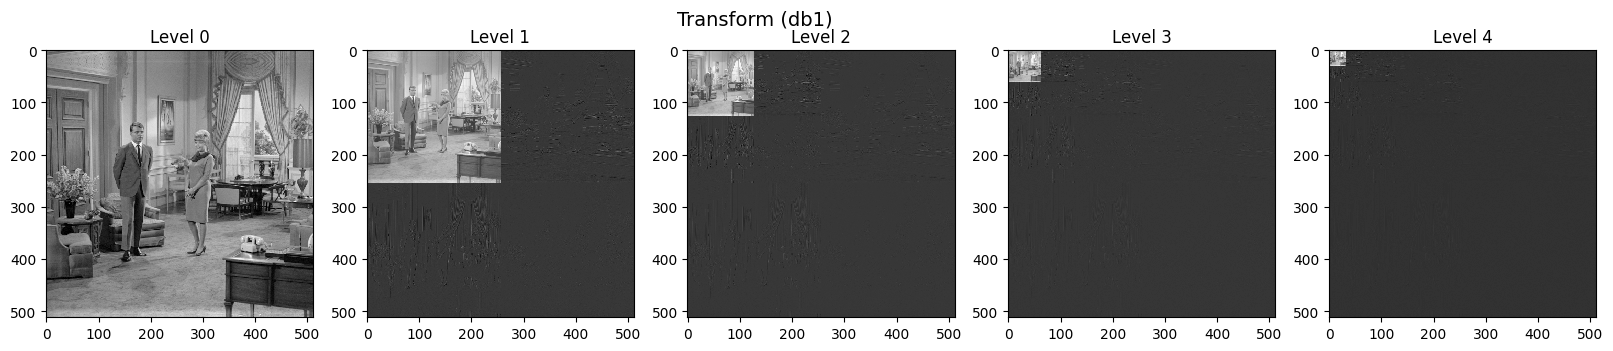

In [25]:
fig, axs = plt.subplots(ncols=K+1, nrows=1, figsize=(4*(K+1), 4))
for k, ax in enumerate(axs.flat):
    if k == 0:
        ax.imshow(f, cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(k))
    else:
        ax.imshow(coeff[k-1], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(k))
plt.text(-250*(K+1), -50, 'Transform (' + wavelet + ')', fontsize=user_fontsize)
plt.savefig('readme_img/transform.png', bbox_inches='tight')
plt.show()

### Обратное преобразование

In [8]:
f_rec = np.empty(K, dtype='object')

for k in reversed(range(K)):
    f_rec[k] = coeff[k].copy()
    cA, (cH, cV, cD) = split_matrices(coeff[k][:Nrow//2**k,:Ncol//2**k])
    f_rec[k][:Nrow//2**k,:Ncol//2**k] = pywt.idwt2((cA, (cH, cV, cD)), wavelet)

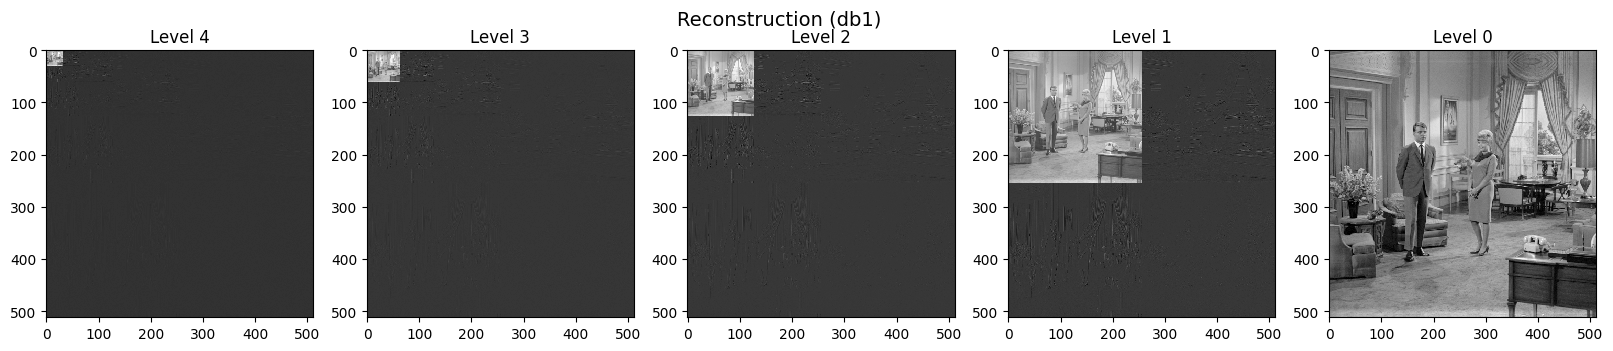

In [26]:
fig, axs = plt.subplots(ncols=K+1, nrows=1, figsize=(4*(K+1), 4))
for k, ax in enumerate(axs.flat):
    if k == 0:
        ax.imshow(coeff[K-1], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(K))
    else:
        ax.imshow(f_rec[K-k], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(K-k))
plt.text(-250*(K+1), -50, 'Reconstruction (' + wavelet + ')', fontsize=user_fontsize)
plt.savefig('readme_img/reconstruction.png', bbox_inches='tight')
plt.show()

Difference (sum squared): 2.1284511178380237e-24


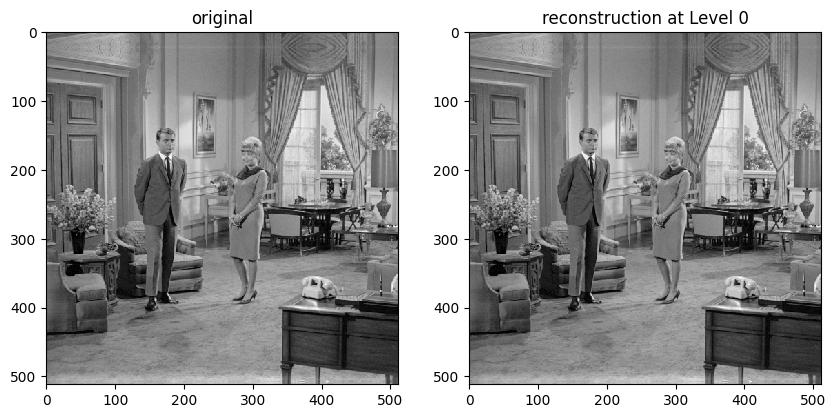

In [27]:
print('Difference (sum squared):', np.sum( (f-f_rec[0])**2 ))
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(f, cmap='gray', interpolation='none')
axs.flat[0].set_title('original')
axs.flat[1].imshow(f_rec[0], cmap='gray', interpolation='none')
axs.flat[1].set_title('reconstruction at Level 0')
plt.savefig('readme_img/comparison.png', bbox_inches='tight')
plt.show()

### Энергия

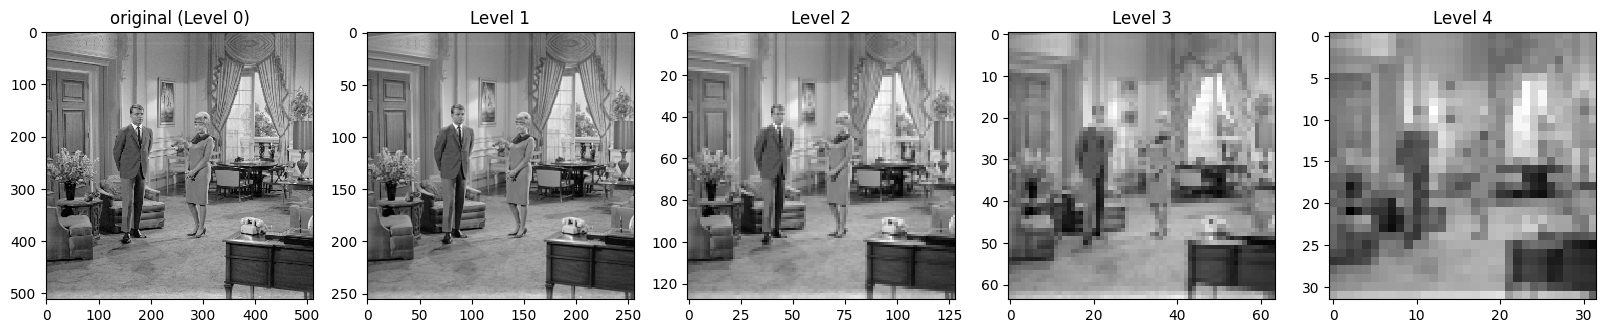

In [11]:
fig, axs = plt.subplots(ncols=K+1, nrows=1, figsize=(4*(K+1), 4))
for k, ax in enumerate(axs.flat):
    if k == 0:
        ax.imshow(f, cmap='gray', interpolation='none')
        ax.set_title('original (Level 0)')
    else:    
        ax.imshow(coeff[k-1][:Nrow//2**k,:Ncol//2**k], cmap='gray', interpolation='none')
        ax.set_title('Level ' + str(k))
plt.savefig('readme_img/trends.png', bbox_inches='tight')
plt.show()

Total Energy (Signal) 66858.44
Total Energy (Coeff) 66858.44


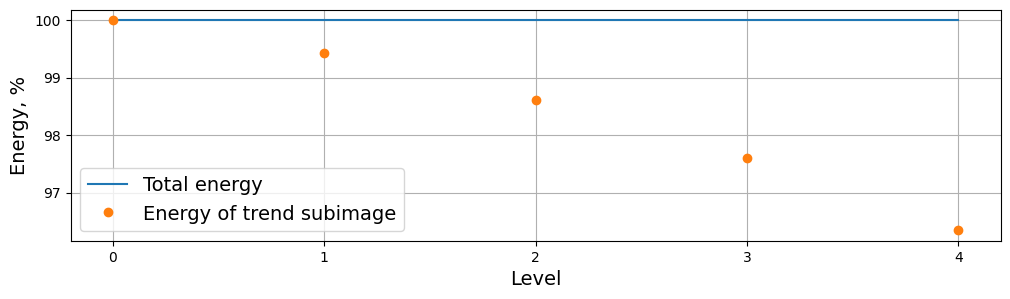

In [16]:
print('Total Energy (Signal)', np.round(np.sum(np.array(f)**2),2))
print('Total Energy (Coeff)', np.round(np.sum(np.array(coeff[0])**2),2))

full_energy_rec = np.sum(np.array(f_rec[0])**2)
full_energy = [100]
trend_energy = [100]
for k in range(1,K+1):   
    full_energy.append(np.sum(np.array(coeff[k-1])**2) / full_energy_rec * 100)
    trend_energy.append(np.sum(np.array(coeff[k-1][:Nrow//2**k,:Ncol//2**k])**2) / full_energy_rec * 100)

fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(12)
ax.plot(full_energy, label='Total energy')
ax.plot(trend_energy, 'o', label='Energy of trend subimage')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel('Level', fontsize=user_fontsize)
plt.ylabel('Energy, %', fontsize=user_fontsize)
plt.grid(True)
plt.legend(fontsize=user_fontsize)
plt.savefig('readme_img/energy_pywt.png', bbox_inches='tight')
plt.show()